<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-+-Data" data-toc-modified-id="Import-Packages-+-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages + Data</a></span></li><li><span><a href="#Explore-+-Clean-Data" data-toc-modified-id="Explore-+-Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore + Clean Data</a></span><ul class="toc-item"><li><span><a href="#Check-For-Null-Values" data-toc-modified-id="Check-For-Null-Values-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check For Null Values</a></span></li><li><span><a href="#Check-For-Duplicates" data-toc-modified-id="Check-For-Duplicates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check For Duplicates</a></span></li><li><span><a href="#Add-TotalPrice-Column" data-toc-modified-id="Add-TotalPrice-Column-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Add TotalPrice Column</a></span></li><li><span><a href="#Remove-Outliers" data-toc-modified-id="Remove-Outliers-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Remove Outliers</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Import Packages + Data

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import data & convert to df
data = pd.read_excel('Data/Online_Retail.xlsx')
df = pd.DataFrame(data)

# Preview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We can see here there are multiple items and quantities purchased on each invoice. I will create another column that shows total spent on each item, so Quantity * UnitPrice. That way we can group by invoice number, customer, etc. and see the total they spent per invoice and item.

We're also going to be adding Recency, Frequency and Monetary columns so we can conduct an RMF analysis and segment customers that way as well. 

Let's take a look at some of the basics before we hop into it. 

# Explore + Clean Data

In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**InvoiceNo** is currently an object. I'm going to change that to an integer so we'll be able to group by invoice number. 

**StockCode** can stay an object, I'm guessing it's a string. 

It's great that **InvoiceDate** is already in datetime format, because we can peak at some time series in the EDA to see if we can collect any further insights. 

## Check For Null Values

In [4]:
# Check for missing values

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

It looks like we have a good amount of Null values for **CustomerID** and **Description**. Let's see how much of the total this accounts for.

In [5]:
# Description
print('Description Percent Null Values:')
print(f"{((df.Description.isnull().sum())/len(df.Description)*100).round(4)} % \n")

# CustomerID
print('CustomerID Percent Null Values:')
print(f"{((df.CustomerID.isnull().sum())/len(df.CustomerID)*100).round(4)} % \n")

print('==============================')

Description Percent Null Values:
0.2683 % 

CustomerID Percent Null Values:
24.9267 % 



The number of missing values for the **Description** column is small, however for the **CustomerID** column it is large at almost 25%. I'm curious how many customers there were. Let's take a look at the number of unique values.

In [6]:
# Unique CustomerIDs

print(f'No. of unique CustomerIDs: \n{len(df.CustomerID.value_counts())}')

No. of unique CustomerIDs: 
4372


Since we still have data from over 4,300 customers, and we don't have any way of identifying the customers with the Null **CustomerID** field, it only makes sense to remove them. And since the number of Null **Description** fields are low, we will remove those as well. 

In [7]:
# Drop rows w/null fields
df = df.dropna()

In [8]:
len(df)

406829

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Check For Duplicates

In [10]:
#df[df.duplicated()]
df[df.InvoiceNo == 536412].duplicated()

541    False
542    False
543    False
544    False
545    False
       ...  
617     True
618     True
619    False
620     True
621    False
Length: 81, dtype: bool

In [11]:
df.iloc[617:622]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
617,536412,22900,SET 2 TEA TOWELS I LOVE LONDON,2,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
618,536412,21706,FOLDING UMBRELLA RED/WHITE POLKADOT,1,2010-12-01 11:49:00,4.95,17920.0,United Kingdom
619,536412,22988,SOLDIERS EGG CUP,6,2010-12-01 11:49:00,1.25,17920.0,United Kingdom
620,536412,85184C,S/4 VALENTINE DECOUPAGE HEART BOX,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
621,536412,20750,RED RETROSPOT MINI CASES,1,2010-12-01 11:49:00,7.95,17920.0,United Kingdom


None of these seem to be duplicates, so we're going to leave these here. 

In [12]:
# Summary statistics

df.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


## Add TotalPrice Column

In [13]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [14]:
df.describe().round(2)

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.00,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69,20.40
std,248.69,69.32,1713.60,427.59
min,-80995.00,0.00,12346.00,-168469.60
25%,2.00,1.25,13953.00,4.20
50%,5.00,1.95,15152.00,11.10
75%,12.00,3.75,16791.00,19.50
max,80995.00,38970.00,18287.00,168469.60


**Explore this further. Are these isolated events of extremely high Quantity ordered and then returned?**

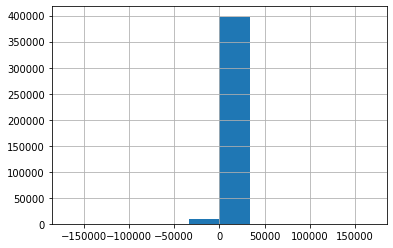

In [15]:
df.TotalPrice.hist();

## Remove Outliers

It looks like there are some major outliers in our dataset. Let's remove them. 

In [16]:
# Percentiles for Quantity

# Define percentiles
percentiles = [0,2.5,97.5,100]

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile Quantity: {}".format(q, df.Quantity.quantile(q=q)))
    
# Percentiles for UnitPrice

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile UnitPrice: {}".format(q, df.UnitPrice.quantile(q=q)))
    
# Percentiles for TotalPrice

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile TotalPrice: {}".format(q, df.TotalPrice.quantile(q=q)))

0.0 percentile Quantity: -80995.0
0.025 percentile Quantity: 1.0
0.975 percentile Quantity: 72.0
1.0 percentile Quantity: 80995.0
0.0 percentile UnitPrice: 0.0
0.025 percentile UnitPrice: 0.39
0.975 percentile UnitPrice: 11.95
1.0 percentile UnitPrice: 38970.0
0.0 percentile TotalPrice: -168469.6
0.025 percentile TotalPrice: 0.39
0.975 percentile TotalPrice: 104.39999999999999
1.0 percentile TotalPrice: 168469.6


I'm going to remove what may be returns or negative **Quantity** values as the lower 1% is -2.0 and the lower 2.5% was 1.0. We also removed all of the negative UnitPrice values when we removed the Null **CustomerID** values. 

We're also going to set the **UnitPrice** lower limit to be any value greater than 0.0 as this means it has any price. The minimum value being 0.001. 

In [17]:
# Remove extreme outliers in the lower and upper 1%

# Get original length to see percent removed
orig_tot = len(df)

# Subset to remove extreme outliers
# Quantity
df = df[(df.Quantity > 0.0) & (df.Quantity <= 120.0)] 
# UnitPrice lot
df = df[(df.UnitPrice > 0.0) & (df.UnitPrice <= 15.0)]

# Calculate percent removed
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.04014954686121196


We saw how removing the rows with Null **CustomerIDs** also removed the negative **UnitPrices**, I'm wondering if it would be best to remove the rows with negative Quantity value as well. We can see here with the 1% being -2.0, the 2% being -1.0 and the 2.5% being 1.0. 

I will keep it standard for now with percentiles, however it ma

It seems returns are extremely rare, which we can see with the **Quantity** 0.01 percentile being -2.0. I'm wondering if returns should be removed alltogether since they are rare, or if there are certain segments of customers who are more prone to returns.

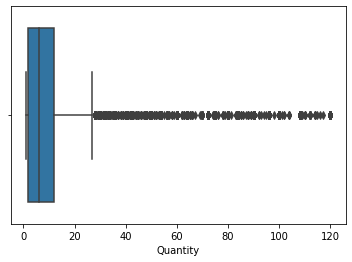

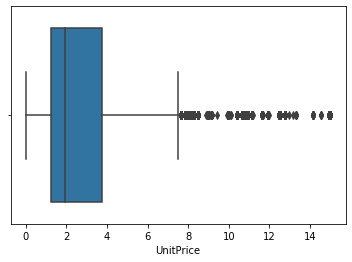

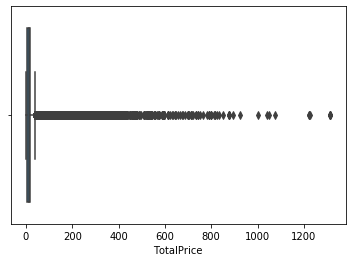

In [18]:
sns.boxplot(df.Quantity)
plt.show()

sns.boxplot(df.UnitPrice)
plt.show()

sns.boxplot(df.TotalPrice)
plt.show()

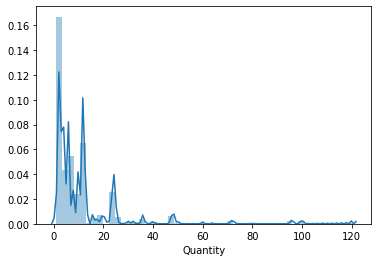

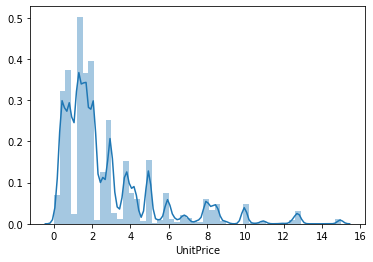

In [19]:
sns.distplot(df.Quantity)
plt.show()
sns.distplot(df.UnitPrice)
plt.show()

It seems that removing the Null **CustomerID** data also removed all of the negative **UnitPrice** values. 

We can see visually there are some major outliers. With this data set it's easy to visually see the outliers, so I could remove them that way, however I'm going to remove them by removing the upper and lower percentiles. 

In [31]:
df[['Quantity','UnitPrice','TotalPrice']]

,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34
...,...,...,...
541904,12,0.85,10.20
541905,6,2.10,12.60
541906,4,4.15,16.60
541907,4,4.15,16.60


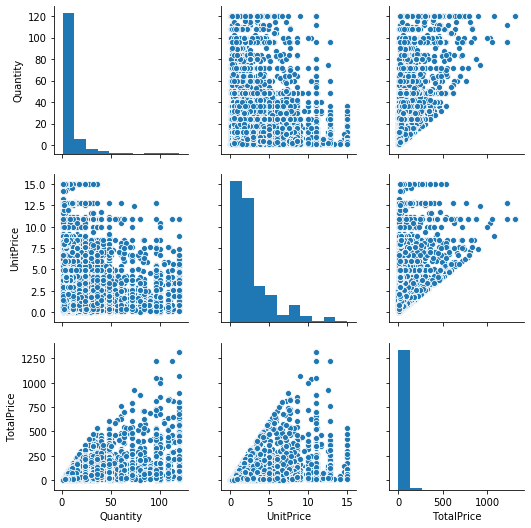

In [32]:
# Pairplot
sns.pairplot(df[['Quantity','UnitPrice','TotalPrice']]);

We can see there appears to be a clear linear relationship between **TotalPrice** and **Quantity** and **TotalPrice** and **UnitPrice**, with no apparent relationship between **UnitPrice** and **Quantity**. This intuitively makes sense as **TotalPrice** is calculated as **Quantity * UnitPrice**. 

We could also take a look at a correlation matrix.

In [38]:
# Correlation matrix

df[['Quantity','UnitPrice','TotalPrice']].corr().round(2)

,Quantity,UnitPrice,TotalPrice
Quantity,1.00,-0.25,0.62
UnitPrice,-0.25,1.00,0.19
TotalPrice,0.62,0.19,1.00


Interesting that there is actually a weak correlation between **UnitPrice** and **TotalPrice** and a weak yet stronger than the former correlation between **UnitPrice** and **Quantity**. 

Let's take a look at the **Country** data. 

In [46]:
# Number of unique invoices
len(df.InvoiceNo.unique())

18014

In [89]:
# Number of unique invoices per country
df.groupby(['Country'])['InvoiceNo'].nunique().sort_values(ascending=False)

Country
United Kingdom          16216
Germany                   441
France                    378
EIRE                      253
Belgium                    98
Spain                      87
Netherlands                85
Australia                  50
Portugal                   48
Switzerland                47
Finland                    40
Italy                      35
Norway                     34
Sweden                     32
Channel Islands            24
Poland                     19
Denmark                    18
Austria                    17
Japan                      16
Cyprus                     15
Unspecified                 8
Iceland                     7
USA                         5
Malta                       5
Greece                      5
Israel                      5
Singapore                   4
Lithuania                   4
Canada                      4
European Community          4
Czech Republic              2
United Arab Emirates        2
Bahrain                     2
Sa

We can see most of the purchases are from the **United Kingdom**. We could model the UK exclusively, however since this is from an online retailer, I'm interested to see if there are similar groups across countries. 

We can always come back and model for the top country or countries (in terms of orders) if we find the model works better that way. 

On that note, I'm curious to see what types of items these customers are purchasing online. Let's take a look at the **Descriptions**.

In [106]:
df.Description.value_counts(ascending=False)[0:20]

WHITE HANGING HEART T-LIGHT HOLDER    1991
REGENCY CAKESTAND 3 TIER              1706
JUMBO BAG RED RETROSPOT               1560
PARTY BUNTING                         1384
ASSORTED COLOUR BIRD ORNAMENT         1355
LUNCH BAG RED RETROSPOT               1312
SET OF 3 CAKE TINS PANTRY DESIGN      1154
LUNCH BAG  BLACK SKULL.               1104
PACK OF 72 RETROSPOT CAKE CASES       1047
PAPER CHAIN KIT 50'S CHRISTMAS        1011
SPOTTY BUNTING                        1010
LUNCH BAG SPACEBOY DESIGN             1003
LUNCH BAG CARS BLUE                    985
NATURAL SLATE HEART CHALKBOARD         978
HEART OF WICKER SMALL                  976
LUNCH BAG PINK POLKADOT                955
REX CASH+CARRY JUMBO SHOPPER           952
LUNCH BAG SUKI DESIGN                  930
ALARM CLOCK BAKELIKE RED               895
LUNCH BAG APPLE DESIGN                 892
Name: Description, dtype: int64

In [108]:
len(df.Description.unique())

3833

There are 3,833 unique descriptions. 

We can see there are a lot of lunch bags. I'm curious if it would be worth creating a category. Like **Description** = 'LUNCH BAG' then a different field with the specific type, or remove it alltogether. 

This wouldn't be as important for an RMF analysis with segmentation. However, for segmentation looking also at types of items purchased, this information would be valuable. 

Let's explore potential categories a bit more. 

In [140]:
df[df.Description.str.contains('LUNCH BAG') == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
93,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 09:37:00,1.65,14688.0,United Kingdom,16.50
174,536385,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2010-12-01 09:56:00,1.65,17420.0,United Kingdom,16.50
363,536401,22662,LUNCH BAG DOLLY GIRL DESIGN,1,2010-12-01 11:21:00,1.65,15862.0,United Kingdom,1.65
368,536401,20725,LUNCH BAG RED RETROSPOT,1,2010-12-01 11:21:00,1.65,15862.0,United Kingdom,1.65
369,536401,22382,LUNCH BAG SPACEBOY DESIGN,2,2010-12-01 11:21:00,1.65,15862.0,United Kingdom,3.30
...,...,...,...,...,...,...,...,...,...
540436,581486,23207,LUNCH BAG ALPHABET DESIGN,10,2011-12-09 09:38:00,1.65,17001.0,United Kingdom,16.50
541695,581538,20727,LUNCH BAG BLACK SKULL.,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom,1.65
541696,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom,1.65
541862,581581,23681,LUNCH BAG RED VINTAGE DOILY,10,2011-12-09 12:20:00,1.65,17581.0,United Kingdom,16.50


Lot's of lunch bag purchases. 

In [139]:
df[df.Description.str.contains('LUNCH BAG') == True].Description.value_counts()

LUNCH BAG RED RETROSPOT          1312
LUNCH BAG  BLACK SKULL.          1104
LUNCH BAG SPACEBOY DESIGN        1003
LUNCH BAG CARS BLUE               985
LUNCH BAG PINK POLKADOT           955
LUNCH BAG SUKI DESIGN             930
LUNCH BAG APPLE DESIGN            892
LUNCH BAG WOODLAND                839
LUNCH BAG ALPHABET DESIGN         667
LUNCH BAG VINTAGE LEAF DESIGN     614
LUNCH BAG DOLLY GIRL DESIGN       609
LUNCH BAG VINTAGE DOILY           557
LUNCH BAG DOILEY PATTERN          470
LUNCH BAG PAISLEY PARK            308
LUNCH BAG SUKI  DESIGN            150
LUNCH BAG RED VINTAGE DOILY       119
Name: Description, dtype: int64

It looks like 'VINTAGE DOILEY' is meant to be 'VINTAGE DOILY'. I can correct that here 

In [119]:
# Rename to match category
df.Description[df.Description == 'LUNCH BAG VINTAGE DOILEY '] = 'LUNCH BAG VINTAGE DOILY '

One customer purchased 40! I wonder what these are for. Businesses, parties, special events? 

In [138]:
df[df.Description.str.contains('LUNCH BAG') == True].Description.value_counts()

LUNCH BAG RED RETROSPOT          1312
LUNCH BAG  BLACK SKULL.          1104
LUNCH BAG SPACEBOY DESIGN        1003
LUNCH BAG CARS BLUE               985
LUNCH BAG PINK POLKADOT           955
LUNCH BAG SUKI DESIGN             930
LUNCH BAG APPLE DESIGN            892
LUNCH BAG WOODLAND                839
LUNCH BAG ALPHABET DESIGN         667
LUNCH BAG VINTAGE LEAF DESIGN     614
LUNCH BAG DOLLY GIRL DESIGN       609
LUNCH BAG VINTAGE DOILY           557
LUNCH BAG DOILEY PATTERN          470
LUNCH BAG PAISLEY PARK            308
LUNCH BAG SUKI  DESIGN            150
LUNCH BAG RED VINTAGE DOILY       119
Name: Description, dtype: int64

Perfect! We can see the 4 rows have been added. 

We can see there are more DOILY/DOILEY categories. I imagine these could all be combined. Let's keep looking and see what other products we have. 

In [137]:
df[df.Description.str.contains('LUNCH BAG') != True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [136]:
# Category of 'CHILDRENS CUTLERY'
df[df.Description.str.contains('CHILDRENS CUTLERY') == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
95267,544450,84997C,CHILDRENS CUTLERY POLKADOT BLUE,5,2011-02-20 12:23:00,4.15,17811.0,United Kingdom,20.75
95268,544450,84997D,CHILDRENS CUTLERY POLKADOT PINK,5,2011-02-20 12:23:00,4.15,17811.0,United Kingdom,20.75
97478,544634,84997C,CHILDRENS CUTLERY POLKADOT BLUE,2,2011-02-22 11:02:00,4.15,17994.0,United Kingdom,8.30
97479,544634,84997B,CHILDRENS CUTLERY RETROSPOT RED,2,2011-02-22 11:02:00,4.15,17994.0,United Kingdom,8.30
97480,544634,84997D,CHILDRENS CUTLERY POLKADOT PINK,2,2011-02-22 11:02:00,4.15,17994.0,United Kingdom,8.30
...,...,...,...,...,...,...,...,...,...
541777,581578,84997B,CHILDRENS CUTLERY RETROSPOT RED,8,2011-12-09 12:16:00,4.15,12713.0,Germany,33.20
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713.0,Germany,33.20
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [135]:
# Line called 'CIRCUS PARADE'
df[df.Description.str.contains('CIRCUS PARADE') == True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
37,536370,22631,CIRCUS PARADE LUNCH BOX,24,2010-12-01 08:45:00,1.95,12583.0,France,46.80
42,536370,22540,MINI JIGSAW CIRCUS PARADE,24,2010-12-01 08:45:00,0.42,12583.0,France,10.08
463,536408,22716,CARD CIRCUS PARADE,12,2010-12-01 11:41:00,0.42,14307.0,United Kingdom,5.04
503,536409,22531,MAGIC DRAWING SLATE CIRCUS PARADE,1,2010-12-01 11:45:00,0.42,17908.0,United Kingdom,0.42
674,536415,22531,MAGIC DRAWING SLATE CIRCUS PARADE,3,2010-12-01 11:57:00,0.42,12838.0,United Kingdom,1.26
...,...,...,...,...,...,...,...,...,...
541775,581578,23255,CHILDRENS CUTLERY CIRCUS PARADE,12,2011-12-09 12:16:00,4.15,12713.0,Germany,49.80
541791,581578,22711,WRAP CIRCUS PARADE,25,2011-12-09 12:16:00,0.42,12713.0,Germany,10.50
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40
541895,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680.0,France,19.80


We can see there are categories of the descriptions and also lines it appears. For example 'SPACE BOY', 'DOLLY GIRL', 'CIRCUS PARADE', etc. across multiple categories such as 'CHILDRENS CUTLERY', 'NAPKINS', 'APRON's and more. 

In [134]:
df.Description[df.Description.str.contains('CIRCUS PARADE') == True].value_counts()

PLASTERS IN TIN CIRCUS PARADE          530
CIRCUS PARADE LUNCH BOX                256
CARD CIRCUS PARADE                     214
CHILDS BREAKFAST SET CIRCUS PARADE     182
MAGIC DRAWING SLATE CIRCUS PARADE      165
CHILDRENS CUTLERY CIRCUS PARADE        144
CIRCUS PARADE CHILDRENS EGG CUP        116
CHILDREN'S CIRCUS PARADE MUG           112
WRAP CIRCUS PARADE                     100
PACK OF 12 CIRCUS PARADE TISSUES        69
MINI JIGSAW CIRCUS PARADE               61
CIRCUS PARADE BABY GIFT SET             21
Name: Description, dtype: int64

In [141]:
df.Description[df.Description.str.contains('PLASTERS IN TIN') == True].value_counts()

PLASTERS IN TIN WOODLAND ANIMALS    600
PLASTERS IN TIN SPACEBOY            589
PLASTERS IN TIN CIRCUS PARADE       530
PLASTERS IN TIN VINTAGE PAISLEY     497
PLASTERS IN TIN SKULLS              464
PLASTERS IN TIN STRONGMAN           455
Name: Description, dtype: int64

In [142]:
df.Description[df.Description.str.contains('LUNCH BOX') == True].value_counts()

SPACEBOY LUNCH BOX                     696
DOLLY GIRL LUNCH BOX                   618
LUNCH BOX I LOVE LONDON                502
STRAWBERRY LUNCH BOX WITH CUTLERY      436
LUNCH BOX WITH CUTLERY RETROSPOT       331
SKULL LUNCH BOX WITH CUTLERY           275
CIRCUS PARADE LUNCH BOX                256
DINOSAUR LUNCH BOX WITH CUTLERY        168
LUNCH BOX WITH CUTLERY FAIRY CAKES      25
Name: Description, dtype: int64

In [143]:
df.Description[df.Description.str.contains('NAPKINS') == True].value_counts()

SET/20 RED RETROSPOT PAPER NAPKINS     750
PACK OF 20 NAPKINS PANTRY DESIGN       563
SET OF 20 VINTAGE CHRISTMAS NAPKINS    505
PACK OF 20 NAPKINS RED APPLES          322
SET 20 NAPKINS FAIRY CAKES DESIGN      297
PACK OF 20 SKULL PAPER NAPKINS         210
SET/20 STRAWBERRY PAPER NAPKINS        205
PACK OF 20 SPACEBOY NAPKINS            114
PACK 20 ENGLISH ROSE PAPER NAPKINS      55
SET/4 MODERN VINTAGE COTTON NAPKINS     23
Name: Description, dtype: int64

In [144]:
df.Description[df.Description.str.contains('FAIRY CAKES') == True].value_counts()

SET 20 NAPKINS FAIRY CAKES DESIGN      297
WRAP PINK FAIRY CAKES                  163
FAIRY CAKES NOTEBOOK A6 SIZE           107
FAIRY CAKES NOTEBOOK A7 SIZE            98
LUNCH BOX WITH CUTLERY FAIRY CAKES      25
Name: Description, dtype: int64

In [145]:
df.Description[df.Description.str.contains('NOTEBOOK') == True].value_counts()

SET OF 3 NOTEBOOKS IN PARCEL           334
JAZZ HEARTS PURSE NOTEBOOK             257
ENGLISH ROSE NOTEBOOK A7 SIZE          225
SMALL PURPLE BABUSHKA NOTEBOOK         197
SMALL RED BABUSHKA NOTEBOOK            193
SMALL YELLOW BABUSHKA NOTEBOOK         168
LARGE PURPLE BABUSHKA NOTEBOOK         128
LARGE RED BABUSHKA NOTEBOOK            113
FAIRY CAKES NOTEBOOK A6 SIZE           107
FAIRY CAKES NOTEBOOK A7 SIZE            98
LARGE YELLOW BABUSHKA NOTEBOOK          93
MADRAS NOTEBOOK MEDIUM                  78
ASSORTED TUTTI FRUTTI  FOB NOTEBOOK     53
CHRYSANTHEMUM NOTEBOOK                  36
ASSORTED TUTTI FRUTTI NOTEBOOK          32
ROMANTIC IMAGES NOTEBOOK SET            28
BLOSSOM  IMAGES NOTEBOOK SET            25
BLUE PAISLEY NOTEBOOK                   24
GREEN FERN NOTEBOOK                     23
DAISY NOTEBOOK                          22
ASSORTED MINI MADRAS NOTEBOOK           22
ENGLISH ROSE NOTEBOOK A6 SIZE           19
VINTAGE BEAD NOTEBOOK                   17
MADRAS NOTE

In [146]:
df.Description[df.Description.str.contains('BABUSHKA') == True].value_counts()

HAND WARMER BABUSHKA DESIGN         296
SET 7 BABUSHKA NESTING BOXES        294
SMALL PURPLE BABUSHKA NOTEBOOK      197
SMALL RED BABUSHKA NOTEBOOK         193
SMALL YELLOW BABUSHKA NOTEBOOK      168
HOT WATER BOTTLE BABUSHKA           135
LARGE PURPLE BABUSHKA NOTEBOOK      128
BABUSHKA LIGHTS STRING OF 10        116
LARGE RED BABUSHKA NOTEBOOK         113
LARGE YELLOW BABUSHKA NOTEBOOK       93
SILK PURSE BABUSHKA PINK             89
MEASURING TAPE BABUSHKA PINK         68
SILK PURSE BABUSHKA BLUE             54
RETROSPOT BABUSHKA DOORSTOP          48
MEASURING TAPE BABUSHKA BLUE         47
GINGHAM BABUSHKA DOORSTOP            42
PIN CUSHION BABUSHKA PINK            41
SILK PURSE BABUSHKA RED              39
MEASURING TAPE BABUSHKA RED          38
PIN CUSHION BABUSHKA RED             34
PIN CUSHION BABUSHKA BLUE            16
SET OF 3 BABUSHKA STACKING TINS       9
HOT WATER BOTTLE BABUSHKA LARGE       1
Name: Description, dtype: int64

In [147]:
df.Description[df.Description.str.contains('HOT WATER BOTTLE') == True].value_counts()

HOT WATER BOTTLE KEEP CALM             738
CHOCOLATE HOT WATER BOTTLE             714
SCOTTIE DOG HOT WATER BOTTLE           670
RETROSPOT HEART HOT WATER BOTTLE       547
GREY HEART HOT WATER BOTTLE            539
HOT WATER BOTTLE TEA AND SYMPATHY      519
HOT WATER BOTTLE I AM SO POORLY        517
LOVE HOT WATER BOTTLE                  472
WHITE SKULL HOT WATER BOTTLE           388
FAWN BLUE HOT WATER BOTTLE             386
KNITTED UNION FLAG HOT WATER BOTTLE    326
CHICK GREY HOT WATER BOTTLE            297
ENGLISH ROSE HOT WATER BOTTLE          287
BIRD HOUSE HOT WATER BOTTLE            163
HOT WATER BOTTLE BABUSHKA              135
CHARLIE + LOLA RED HOT WATER BOTTLE    132
CHARLIE+LOLA PINK HOT WATER BOTTLE     108
HOT WATER BOTTLE SEX BOMB               91
HOT STUFF HOT WATER BOTTLE              68
CHARLIE+LOLA RED HOT WATER BOTTLE       50
CHARLIE LOLA BLUE HOT WATER BOTTLE      38
PINK HEART DOTS HOT WATER BOTTLE         4
RED WHITE SCARF  HOT WATER BOTTLE        2
UNION JACK 

In [149]:
df.Description[df.Description.str.contains('CHARLIE','LOLA') == True].value_counts()

CHARLIE + LOLA RED HOT WATER BOTTLE    132
CHARLIE AND LOLA FIGURES TINS          127
RED CHARLIE+LOLA PERSONAL DOORSIGN     110
JUMBO BAG CHARLIE AND LOLA TOYS        109
CHARLIE+LOLA PINK HOT WATER BOTTLE     108
CHARLIE & LOLA WASTEPAPER BIN FLORA    107
CARROT CHARLIE+LOLA COASTER SET         93
BLUE CHARLIE+LOLA PERSONAL DOORSIGN     92
CHARLIE & LOLA WASTEPAPER BIN BLUE      83
CHARLIE+LOLA"EXTREMELY BUSY" SIGN       73
CHARLIE+LOLA MY ROOM DOOR SIGN          66
TOMATO CHARLIE+LOLA COASTER SET         61
CHARLIE AND LOLA TABLE TINS             60
CHARLIE + LOLA BISCUITS TINS            52
CHARLIE+LOLA RED HOT WATER BOTTLE       50
CHARLIE LOLA BLUE HOT WATER BOTTLE      38
CHARLIE AND LOLA CHARLOTTE BAG           8
Name: Description, dtype: int64

As we can see there are numerous different categories and lines of products. These could be broken down into categories and even colors for deeper insights and analyses. This would be a project in itself. For now I will continue to conduct an RMF analysis. However, for future work I believe it would be valuable to find groups of buyers based also on the types of categories they purchases. 

# Future Work

We can see there are many categories of products, such as napkins, aprons, notebooks, water bottles, lunch bags, etc. And across those categories there are many different lines of products, such as 'SPACE BOY', 'DOLLY GIRL', 'CIRCUS PARADE', 'CHARLIE + LOLA', and even 'BABUSHKA'. 

Greater insights could be attained by adding categories and lines. This could support more targeted advertising directly to its current customers, which would increase customer experience, engagement and revenue. It could also support targeted digital advertising such as Facebook and Google Ads. 

It the retailer doesn't already have it in place, they could add a recommendation system to increase price per transaction, revenue and customer lifetime values. 